# Package Import

In [1]:
import os
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

plt.style.use("seaborn-whitegrid")

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use("seaborn-whitegrid")
%matplotlib inline
import itertools

# Data description

AirPassengers.csv
- 1949~1960년 매달 비행깅 탑승객 수에 대한 시계열 데이터
- 데이터 구조 : [144*1]

In [2]:
data = pd.read_csv("Data/AirPassengers.csv")
data = data.rename(columns={"Month" : "month", "#Passengers": "passengers"})
data["month"] = pd.to_datetime(data["month"])
data = data.set_index("month")
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## Box-Jenkins ARIMA Procedure
1. Data Preprocessing
2. Identify Model to be Tentatively Entertained
3. Estimate Parameters
4. Diagnosis Check
5. use Model to Forecast

### 1. Data Preprocessing
시간이 지날 수록 데이터가 증가하고 트렌드가 있는것을 확인할 수 있습니다.

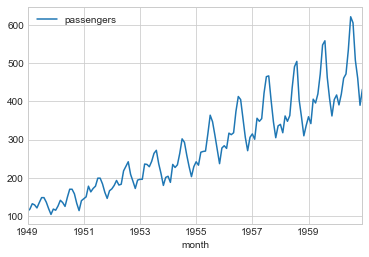

In [3]:
fig = data.plot()

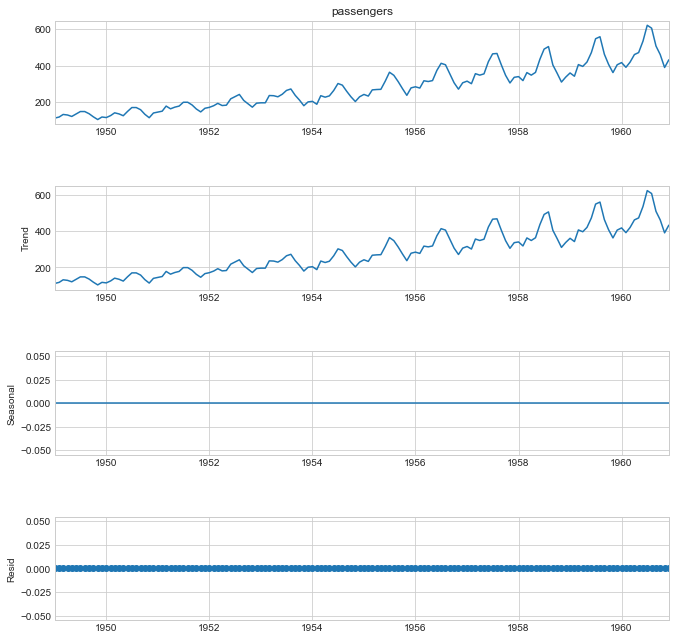

In [4]:
# 1. raw_data : trend + seasonal + resid
# 2. trend
# 3. Seasonal
# 4. rasid 

decomposition = sm.tsa.seasonal_decompose(data["passengers"], model="additive", period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

### 2. Identify Model to be Tentatively Entertained

In [5]:
# 시계열 데이터 이므로 shuffle은 하지않음 (8:2)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [41]:
sm.tsa.stattools.acf(test_data['passengers'], nlags=10, fft=False)

array([ 1.        ,  0.76285738,  0.40831458,  0.07985246, -0.12154446,
       -0.22375043, -0.29626597, -0.2970513 , -0.28490488, -0.15359528,
        0.06559996])

In [42]:
sm.tsa.stattools.pacf(test_data['passengers'], nlags=10, method='ywm')

array([ 1.        ,  0.76285738, -0.41535076, -0.12764432,  0.02105905,
       -0.09424808, -0.18563056,  0.04859231, -0.14944831,  0.2355474 ,
        0.18228483])

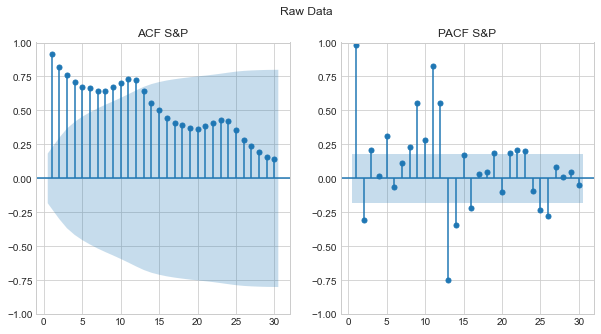

In [6]:
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Raw Data")

sgt.plot_acf(train_data.values, lags = 30, zero = False, ax=ax[0])
ax[0].set_title("ACF S&P")


sgt.plot_pacf(train_data.values, lags = 30, zero = False, method = ('ols'), ax=ax[1])
ax[1].set_title("PACF S&P")

plt.show()

ACF 그래프가 지수적 도는 사인함수 형태로 감소하지 않기 때문에 non-stationary란 것을 알 수 있습니다.  
정상성을 나타내지 않는 데이터는 차분을 수행합니다.
- 차분 : 현 시점 데이터에서 d 시점 이전 데이터를 뺀 것

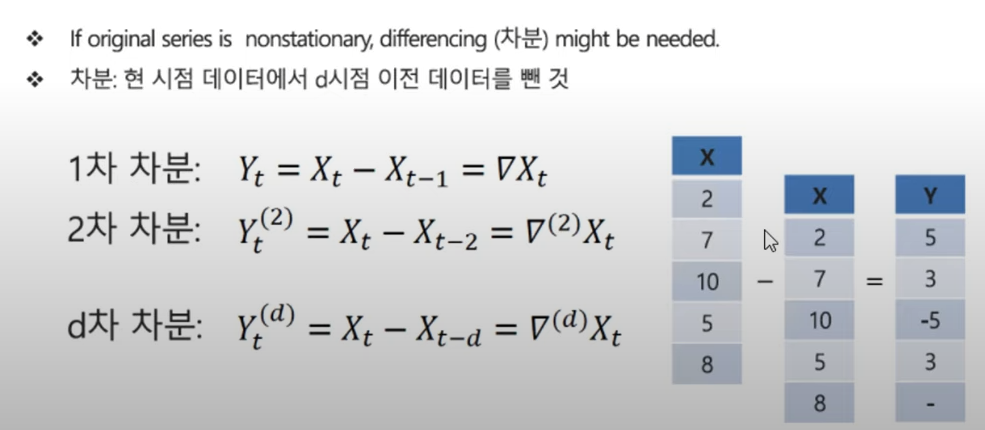

In [7]:
# 차분을 하게 되면 마지막 값이 비게 되어 결측치를 채워줘야함

diff_train_data = train_data.copy()
diff_train_data = diff_train_data["passengers"].diff()
diff_train_data = diff_train_data.dropna()

print("#### Raw Data ####")
print(train_data)
print("#### Diff Data ####")
print(diff_train_data)

#### Raw Data ####
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
#### Diff Data ####
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


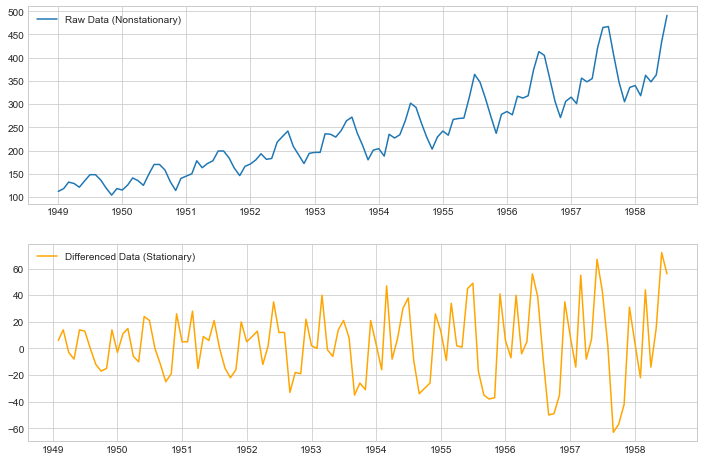

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data["passengers"])
plt.legend(["Raw Data (Nonstationary)"])
plt.subplot(212)
plt.plot(diff_train_data, "orange")
plt.legend(["Differenced Data (Stationary)"])

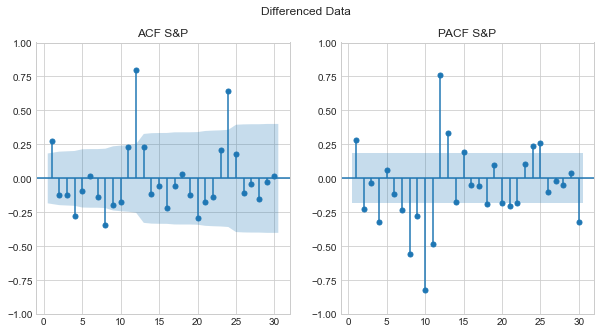

In [9]:
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Differenced Data")

sgt.plot_acf(diff_train_data.values, lags = 30, zero = False, ax=ax[0])
ax[0].set_title("ACF S&P")

sgt.plot_pacf(diff_train_data.values, lags = 30, zero = False, method = ('ols'), ax=ax[1])
ax[1].set_title("PACF S&P")

plt.show()

## Identification ARIMA Model
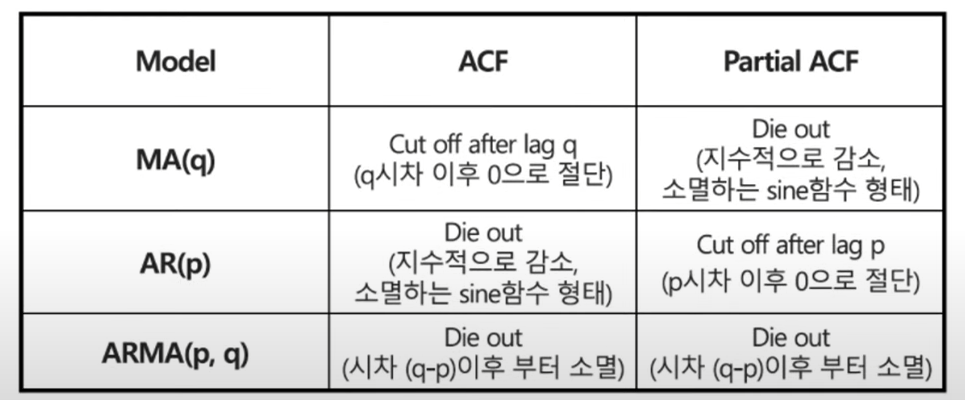

### 3. Estimate Parameters

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# PACF = 1에서 유의 수준보다 크기 떄문에 p = 1
# 차분을 한번 시킨 후 확인 했기 때문에 d = 1 
# (p, d, q) = (1, 1, 0)
# The (p, d, q) order of the model for the number of AR parmeters, differences, and MA parameters to use.
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Fri, 17 Jun 2022   AIC                           1068.536
Time:                        09:48:32   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box test를 활용하여, 잔차들이 white noise 인지를 확인해보겠습니다.  
Ljung-Box test는 귀무가설이 잔차들이 white noise란 것이며,  
대립가설은 잔차들이 white noise가 아니다 라는 것을 나타냅니다.

### 4. Diagnosis Check

In [11]:
print("Examples of parameter combinations for Seasonal ARIMA...")

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

aic = []

for i in pdq :
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f"ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}" )
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA : (0, 1, 0) >> AIC : 1076.27
ARIMA : (0, 1, 1) >> AIC : 1063.65
ARIMA : (0, 1, 2) >> AIC : 1060.69
ARIMA : (1, 1, 0) >> AIC : 1068.54
ARIMA : (1, 1, 1) >> AIC : 1058.25
ARIMA : (1, 1, 2) >> AIC : 1057.33
ARIMA : (2, 1, 0) >> AIC : 1065.64
ARIMA : (2, 1, 1) >> AIC : 1058.65
ARIMA : (2, 1, 2) >> AIC : 1057.52


In [12]:
# Search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), 1057.33)]

In [13]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Fri, 17 Jun 2022   AIC                           1057.328
Time:                        09:48:33   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5. use Model to Forecast

In [14]:
pred_value = model_opt_fit.forecast(steps=len(test_data))
r2 = r2_score(test_data, pred_value)

In [15]:
test_data["ARIMA_pred"] = pred_value

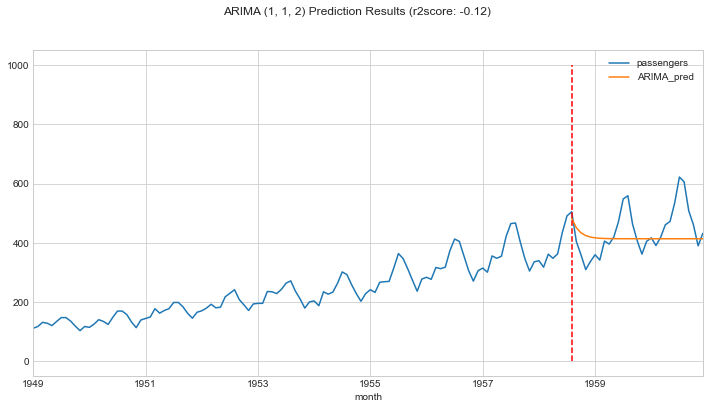

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
test_data[["ARIMA_pred"]].plot(ax=ax)
#ax.plot(test_data["month"], yhat)
ax.vlines("1958-08-01", 0, 1000, linestyle="--", color="r", label="Start of Forecast")
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Results (r2score: {round(r2,2)})")
plt.show()

In [17]:
# pred = model_opt_fit.get_forecast(steps=len(test_data))
# yhat = pred.predicted_mean
# pred_conf = pred.conf_int(alpha=0.05)

## SARIMA
### 1. Diagnosis Check - SARIMA

In [18]:
print("Examples of parameter combinations for Seasonal ARIMA...")

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

# 12 : 12달마다 패턴이 있다고 판단

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        # 중간중간 연산이 안되는 파라미터 조합이 있기 때문에 try except문으로 구현함 
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f"SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}")
            aic.append(round(model_fit.aic, 2))
            params.append((i,j))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.89
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 760.23
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : 757.81
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : 759.75
SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : 753.5
SARIMA: (0, 1, 2)(2, 1, 0, 12) >> AIC : 759.64
SARIMA: (0, 1, 2)(2, 1, 1, 12) >> AIC : 755.49
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : 755.5
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : 755.98
SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : 757.1
SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : 755.75
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : 757.65
SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : 751.15
SARIMA: (1, 1, 0)(2, 1, 0, 12) >> AIC : 757.45
SARIMA: (1, 1, 0)(2, 1, 1, 12) >> AIC : 752.98
SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : 756.02
SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : 756.63
SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : 757.75
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : 756.41
SARIMA: (1, 1, 1

C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : 752.53
SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : 758.03
SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : 754.17
SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : 760.18
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : 757.92
SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : 758.44
SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : 759.63
SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : 758.22
SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : 760.1


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : 754.53
SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : 759.92
SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : 756.17
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : 756.77
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : 757.23
SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : 758.31
SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : 756.98
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : 758.86
SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : 752.78
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : 758.65
SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : 754.51


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : 760.85
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : 757.98
SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : 758.54
SARIMA: (2, 1, 1)(0, 1, 2, 12) >> AIC : 759.69
SARIMA: (2, 1, 1)(1, 1, 0, 12) >> AIC : 758.31
SARIMA: (2, 1, 1)(1, 1, 1, 12) >> AIC : 760.18


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : 754.53
SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : 759.98
SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : 756.17
SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : 762.25
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : 755.2
SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : 755.99
SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : 759.77
SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : 755.82
SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : 757.71
SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : 752.34
SARIMA: (2, 1, 2)(2, 1, 0, 12) >> AIC : 757.56
SARIMA: (2, 1, 2)(2, 1, 1, 12) >> AIC : 753.96
SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : 761.14


C:\Users\bsy37\anaconda3\envs\adp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Search optomal

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

In [20]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1], enforce_stationarity=False, enforce_invertibility=False)
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -284.756
Date:                                 Fri, 17 Jun 2022   AIC                            579.512
Time:                                         09:49:36   BIC                            591.231
Sample:                                              0   HQIC                           584.200
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.111     -2.775      0.006      -0.525      -0.090
ar.S.L12       1.0297      0.083     12.358      0.000       0.866       1.193
ma.S.L12      -1.4820   2038.302     -0.001      0.999   -3996.481    3993.517
ma.S.L24       0.4819    982.453      0.000      1.000   -1925.091    1926.055
sigma2        67.4570   1.37e+05      0.000      1.000   -2.69e+05     2.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.92   Prob(JB):                         0.40
Heteroskedasticity (H):               0.62   Skew:                             0.35
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

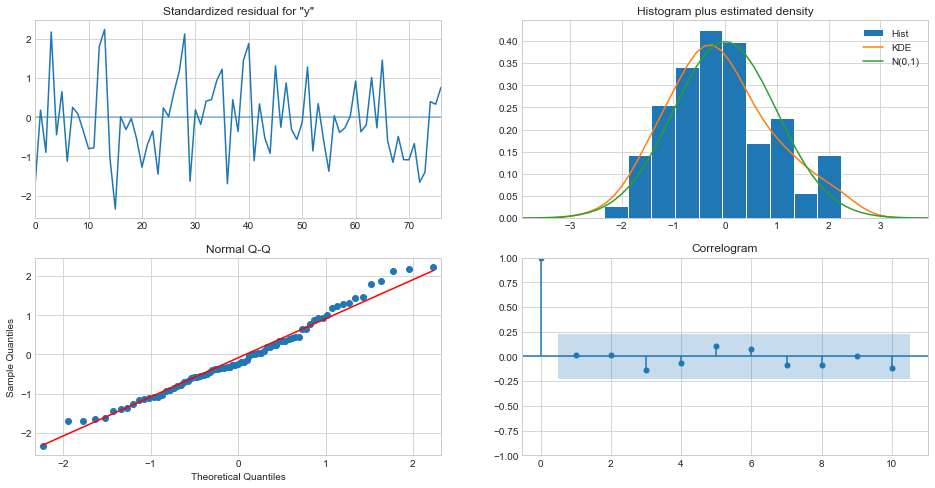

In [21]:
model_opt_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### 2. use Model to Forecast - SARIMA

In [22]:
prediction = model_opt_fit.get_forecast(steps=len(test_data))
predicted_value = prediction.predicted_mean
predicted_ci = prediction.conf_int()
predict_index = list(test_data.index)
r2 = r2_score(test_data["passengers"], predicted_value)

In [23]:
test_data["SARIMA_pred"] = predicted_value

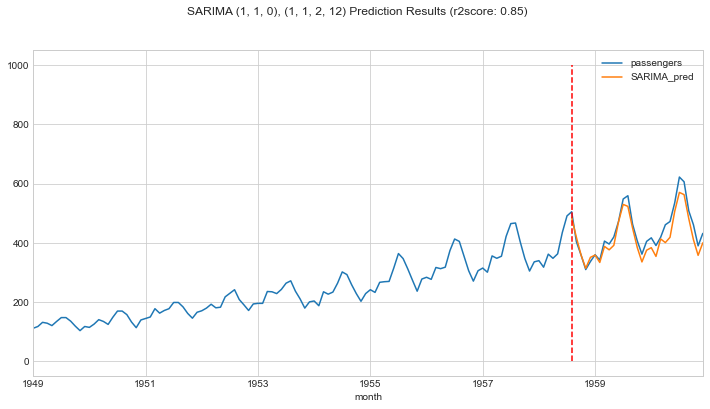

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
test_data[["SARIMA_pred"]].plot(ax=ax)
#ax.plot(test_data["month"], yhat)
ax.vlines("1958-08-01", 0, 1000, linestyle="--", color="r", label="Start of Forecast")
plt.suptitle(f"SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2score: {round(r2,2)})")
plt.show()

## auto_arima
### 1. Diagnosis Check - auto_arima

In [26]:
auto_arima_model = auto_arima(train_data["passengers"], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action="ignore",
                              suppress_warnings=True,
                              stepwise=False
                             )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.32 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.51 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=1.47 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.27 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=1.99 sec
 ARIMA(0,1,1)(0,1,0)[1

In [28]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Fri, 17 Jun 2022   AIC                            752.557
Time:                                            09:54:47   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2. use Model to Frecast - auto arima

In [35]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data["passengers"], predicted_value)

In [36]:
test_data["auto_ARIMA_pred"] = predicted_value

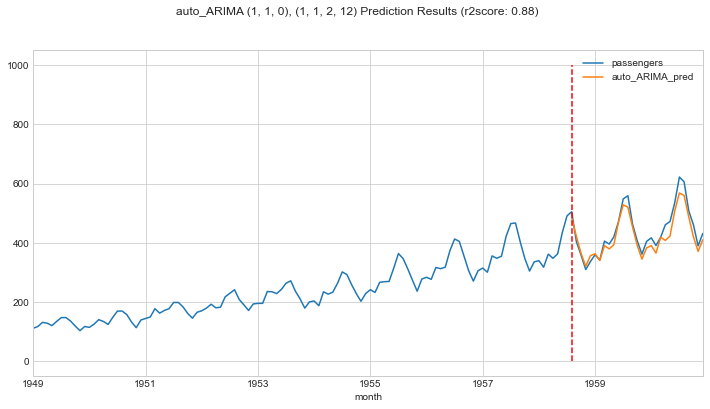

In [44]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
test_data[["auto_ARIMA_pred"]].plot(ax=ax)
#ax.plot(test_data["month"], yhat)
ax.vlines("1958-08-01", 0, 1000, linestyle="--", color="r", label="Start of Forecast")
plt.suptitle(f"auto_ARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2score: {round(r2,2)})")
plt.show()